# Face recognition using neural network features

In this task, you have to construct face recognizer based on features extracted from the neural network. The task consists of two parts: image classification and video classification. In the first one you should classify distinct images and in the second one you will deal with short video sequences.

In [1]:
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%pylab inline
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from copy import copy
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


First of all, you have you have to read the data. Run the cell below to unpack data.

In [3]:
from get_data import unpack
unpack('Face_Recognition_data.zip')

### Reading data for image and video classification (1 point)

Implement function $\tt{load}$\_$\tt{image}$\_$\tt{data}$. It should return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing ones. The keys of the dictionaries are the names of the image files and the values are 3-dimensional numpy arrays (for images) or strings with the names (for labels).

$\tt{dir}$\_$\tt{name}$ is the name of directory with data for image classification. If 'Face_Recofnition_data' directory is located in the same directory as this notebook, then the default value can be used.

In [4]:
import skimage.io as skio
import os
import pandas as pd

def load_img_data(data_dir, role):
    y = pd.read_csv(os.path.join(data_dir, 'y_%s.csv' % role), header = 0) \
                                .set_index('filename') \
                                .to_dict() \
                                ['class_id']

    x = {}
    for f in os.listdir(os.path.join(data_dir, 'images')):
        x[f] = skio.imread(os.path.join(data_dir, 'images', f))
    
    return x, y

def load_image_data(dir_name = 'Face_Recognition_data/image_classification'):
    results = {}
    
    for role in ['train', 'test']:
        x, y = load_img_data(os.path.join(dir_name, role), role)
        
        results['x_%s' % role] = x
        results['y_%s' % role] = y
            
    return results['x_train'], results['y_train'], results['x_test'], results['y_test']

In [5]:
x_train, y_train, x_test, y_test = load_image_data()
print('%d'%len(x_train), '\ttraining images')
print('%d'%len(x_test), '\ttesting images')

661 	training images
808 	testing images


In [6]:
def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    for n,i in enumerate(np.random.choice(list(data.keys()), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(function([data[i]]))
        plt.title(labels[i])
    plt.show()

That is how the data looks like.

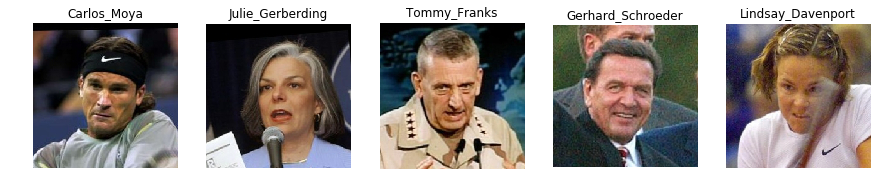

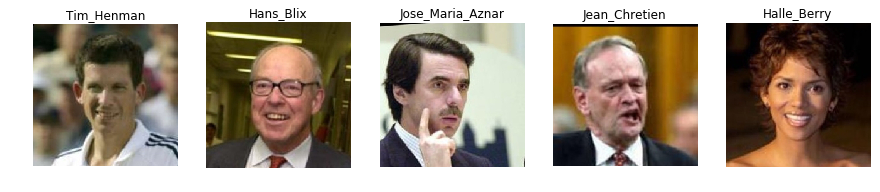

In [7]:
visualize(x_train, y_train)
visualize(x_test, y_test)

Let us now read the video classification data, as well. You have to implement function to load video data.

Function $\tt{load}$\_$\tt{video}$\_$\tt{data}$ should also return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing videos and labels. The training data is in the same format as in image classification task. The keys of testing data and labels are video ids and the values are the lists of frames and the strings with names, respectively.

In [8]:
def load_video_data(dir_name = 'Face_Recognition_data/video_classification'):
    video_train, train_labels = load_img_data(os.path.join(dir_name, 'train'), 'train')
    
    test_labels = pd.read_csv(os.path.join(dir_name, 'test', 'y_test.csv'), header = 0, dtype = {'filename': str}) \
                        .set_index('filename') \
                        .to_dict() \
                        ['class_id']
                
    video_test = {}
    videos_dir = os.path.join(dir_name, 'test', 'videos')
    
    for video_id in os.listdir(videos_dir):
        video_test[video_id] = []
        for i in range(len(os.listdir(os.path.join(videos_dir, video_id)))):
            video_test[video_id].append(skio.imread(os.path.join(videos_dir, video_id, "%d.jpg" % i)))
                
    return video_train, train_labels, video_test, test_labels

In [9]:
video_train, train_labels, video_test, test_labels = load_video_data()
print('%d'%len(video_train), '\ttraining images')
print('%d'%len(video_test), '\ttesting videos')

729 	training images
70 	testing videos


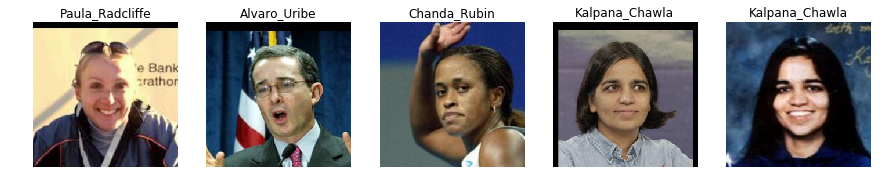

In [10]:
visualize(video_train, train_labels)

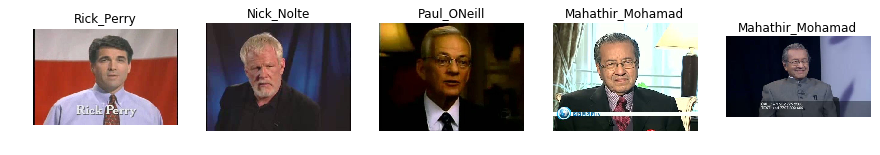

In [11]:
visualize({i:video_test[i][1] for i in video_test}, test_labels)

### Preprocessing (3 points)
You have to implement preprocessing function in the cell below.
Getting a list of images as an input the this function should detect the face on each image, find the facial keypoints () and then crop and normalize the image according to these keypoints. The output of this function is the list of images which contain only the aligned face and should be converted to the tensor of the shape $(N, 224, 224, 3)\ $ where $N$ is the length of the initial list. You can add extra arguments to the preprocess function if necessary (i.e. flag $\tt{is}$\_$\tt{video}$ to determine if the list of images is video sequence or not).

For face detection and facial keypoint regression you can use your models from the previous tasks.

In [12]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)
from skimage.transform import rescale
from keras.models import load_model
from skimage.feature import peak_local_max
from skimage.transform import rotate
from skimage.util import pad
from skimage.transform import resize
import math
import cv2 as cv

def get_bboxes_and_decision_function(fcnn_model, images):
    pred_bboxes, decision_function = [], []
   
    # Predict
    scale_factor = 4
    predictions = np.exp(fcnn_model.predict(images))
    
    padded_preds = np.zeros((predictions.shape[0], predictions.shape[1] + 2, predictions.shape[2] + 2, predictions.shape[3]))
    padded_preds[:, 1:-1, 1:-1, :] = predictions
    
    for i in range(padded_preds.shape[0]):
        pos_score = padded_preds[i, :, :, 1]
        neg_score = padded_preds[i, :, :, 0]
        
        scores = pos_score / (0.00000001 + pos_score + neg_score)
        
        output = peak_local_max(scores, min_distance=2, threshold_abs = 0.1, indices = True, num_peaks = 1)
        
        if output.shape[0] == 0:
            pred_bboxes.append(None)
            decision_function.append(-float('inf'))
        else:
            r = output[0, 0]
            c = output[0, 1]

            pred_bboxes.append((r * scale_factor, c * scale_factor, r * scale_factor + 32, c * scale_factor + 32))
            decision_function.append(scores[r, c])
        
    return pred_bboxes, decision_function


def get_keypoint_regression_model():
    return load_model('face_keypoint_model.hdf5')

def get_face_detection_model():
    return load_model('face_detection_model.hdf5')

def scale_img_to_size(img, img_size):
    scale_factor = 1. * img_size / max(img.shape[:2])
    scaled_img = rescale(img, scale_factor)

    img_border = np.zeros((176, 176, 3))
    img_border[:scaled_img.shape[0], :scaled_img.shape[1], :] = scaled_img
    return img_border

# def crop_to_faces(imgs):
#     face_detect_model = get_face_detection_model()
    
#     sizes = [176 - 5 * i for i in range(25)]
    
#     best_bboxes = {}
    
#     for img_size in sizes:
#         scaled_imgs = []
        
#         for img in imgs:
#             scaled_imgs.append(scale_img_to_size(img, img_size))
        
#         scaled_imgs = np.array(scaled_imgs)
        
#         bboxes, scores = get_bboxes_and_decision_function(face_detect_model, scaled_imgs)
        
#         for i in range(len(imgs)):
#             if i not in best_bboxes or scores[i] > best_bboxes[i][0]:
#                 best_bboxes[i] = (scores[i], bboxes[i], img_size)
                
#     best_imgs = []
    
#     for i in range(len(imgs)):
#         _, bbox, img_size = best_bboxes[i]
#         r0, c0, r1, c1 = bbox
        
#         scale_factor = 1. * img_size / max(imgs[i].shape[:2])
        
#         r0 = int(r0 / scale_factor)
#         c0 = int(c0 / scale_factor)
#         r1 = int(r1 / scale_factor)
#         c1 = int(c1 / scale_factor)
        
#         best_imgs.append(iamgs[i][r0:r1+1, c0:c1+1])
        
#     return best_imgs

def crop_to_faces(imgs, face_border = 15):
    face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml')
    
    cropped_img = []
    borders = []
    for img in imgs:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        faces = face_cascade.detectMultiScale(gray, 1.3, 3)
        
        if len(faces) == 0:
            cropped_img.append(img)
            borders.append((0, 0, 0, 0))
            continue
        
        sizes = [faces[i][2] * faces[i][3] for i in range(len(faces))]
        
        x, y, w, h = faces[np.argmax(sizes)]
        s = max(w, h)

        b_top = min(y, face_border)
        b_right = min(face_border, img.shape[1] - x - s)
        b_bottom = min(face_border, img.shape[0] - y - s)
        b_left = min(x, face_border)

        cropped_img.append(img[y-b_top:y+s+b_bottom, x-b_left:x+s+b_right])
        borders.append((b_top, b_right, b_bottom, b_left))
        
    return cropped_img, borders

def get_keypoints(cropped_imgs, face_borders):
    keypoint_model = get_keypoint_regression_model()
    
    cropped_resized_imgs = []
    for i in range(len(face_borders)):
        img = cropped_imgs[i]
        b_top, b_right, b_bottom, b_left = face_borders[i]
        img = img[b_top:, b_left:]
        if b_bottom > 0:
            img = img[:-b_bottom, :]
        if b_right > 0:
            img = img[:, :-b_right]
            
        try:
            cropped_resized_imgs.append(resize(img, (100, 100)))
        except:
            print(img)
            print(cropped_imgs[i].shape)
            print(face_borders[i])
            raise ValueError()
            
    cropped_resized_imgs = np.array(cropped_resized_imgs)
                                    
#     cropped_imgs = np.array([resize(img[face_border:-face_border, face_border:-face_border], (100, 100)) for img in cropped_imgs])
    return keypoint_model.predict(cropped_resized_imgs)

# def get_keypoints(cropped_imgs, face_borders):
#     eye_cascade = cv.CascadeClassifier('haarcascade_eye.xml')
#     keypoint_model = get_keypoint_regression_model()
    
#     eye_pts = []
#     for i in range(len(face_borders)):
#         img = cropped_imgs[i]
#         b_top, b_right, b_bottom, b_left = face_borders[i]
#         img = img[b_top:, b_left:]
#         if b_bottom > 0:
#             img = img[:-b_bottom, :]
#         if b_right > 0:
#             img = img[:, :-b_right]
            
# #         print(img.shape)
# #         print(img.dtype)
#         start_size = img.shape
#         scale_size = 120
#         gray_img = cv.cvtColor((255 * resize(img, (scale_size, scale_size))).astype(np.uint8), cv.COLOR_BGR2GRAY)
        
#         p = 3
#         used_vals = set()
#         while True:
#             eyes = eye_cascade.detectMultiScale(gray_img, 1.3, p)
# #             print(p, len(eyes))
#             if len(eyes) == 2 or p in used_vals or p < 0:
#                 break
                
#             used_vals.add(p)
#             if len(eyes) < 2:
#                 p -=1
#             else:
#                 p += 1
            
            
# #         print(len(eyes))
#         if len(eyes) == 2:
#             e1_x = int((start_size[1] / scale_size) * (eyes[0][0] + eyes[0][2] // 2))
#             e1_y = int((start_size[0] / scale_size) * (eyes[0][1] + eyes[0][3] // 2))
#             e2_x = int((start_size[1] / scale_size) * (eyes[1][0] + eyes[1][2] // 2))
#             e2_y = int((start_size[0] / scale_size) * (eyes[1][1] + eyes[1][3] // 2))
#             eye_pts.append((e1_x, e1_y, e2_x, e2_y, 0))
# #             eye_pts.append((eyes[0][0] + eyes[0][2] // 2, eyes[0][1] + eyes[0][3] // 2, eyes[1][0] + eyes[1][2] // 2, eyes[1][1] + eyes[1][3] // 2, 0))
#         else:
#             kps = keypoint_model.predict(np.expand_dims(resize(img, (100, 100)), 0))[0]
            
#             scale = img.shape[0]
#             eye_pts.append((int(kps[12] * 1.05 * scale + scale / 2), int(kps[13] * 1.05 * scale + scale / 2), int(kps[16] * 1.05 * scale + scale / 2), int(kps[17] * 1.05 * scale + scale / 2), 255))
            
#     return np.array(eye_pts)
            

def transform_face(image, eyes, eye_prop = 0.22):
    # Step 1: Find the angle between the segment connecting two eyes and horizontal line
    if eyes[0][0] < eyes[1][0]:
        c_l, r_l = eyes[0]
        c_r, r_r = eyes[1]
    elif eyes[0][0] > eyes[1][0]:
        c_l, r_l = eyes[1]
        c_r, r_r = eyes[0]
    else:
#         print('same eye')
        return resize(image, (224, 224))
        
    dr = r_r - r_l
    dc = c_r - c_l
    
    theta = 180 * np.arctan2(dr, dc) / math.pi
    
    # Step 2: Rotate the image    
    rotated_img = rotate(image, theta, center = (c_l, r_l))
    
    # Step 3: Find the coordinates of the eyes on the rotated image
    eye_dist = sqrt(dr**2 + dc**2)
    c_r = c_l + eye_dist
    r_r = r_l
    
    # Step 4: Find the width and height of the box containing the face depending on the eyes coordinates
    box_sz = int(eye_dist / eye_prop)
    
    # Step 5: Crop the box and resize it to 224×224
    face_img = np.zeros((box_sz, box_sz, 3))
    r_min = int(r_r - box_sz // 2)
    r_max = r_min + box_sz
    r_before_pad = max(-r_min, 0)
    r_after_pad = max(r_max - image.shape[0], 0)
        
    c_min = int((c_l + c_r) / 2 - box_sz / 2)
    c_max = c_min + box_sz
    c_before_pad = max(-c_min, 0)
    c_after_pad = max(c_max - image.shape[1], 0)
    
    padded_image = pad(rotated_img, [(r_before_pad, r_after_pad), (c_before_pad, c_after_pad), (0, 0)], mode = 'constant', constant_values = 0)
    r_min += r_before_pad
    r_max += r_before_pad
    c_min += c_before_pad
    c_max += c_before_pad
    
#     print("")
#     print(image.shape)
#     print(eyes)
#     print(r_min, r_max, c_min, c_max)
    
    face_img[:, :, :] = padded_image[r_min : r_max, c_min : c_max, :]
    
    return resize(face_img, (224, 224))

def preprocess_imgs(imgs, face_border = 100):
    cropped_imgs, borders = crop_to_faces(imgs, face_border = face_border)
    keypoints = get_keypoints(cropped_imgs, borders)
    
#     eyes = []
#     for i in range(len(imgs)):
#         b_top, b_right, b_bottom, b_left = borders[i]
        
#         scale = cropped_imgs[i].shape[0] - b_top - b_bottom
#         offset = scale // 2
        
#         eyes.append([(keypoints[i, 0] + b_left, keypoints[i, 1] + b_top), (keypoints[i, 2] + b_left, keypoints[i, 3] + b_top)])

#         cropped_imgs[i][eyes[-1][0][1], eyes[-1][0][0], :] = keypoints[i, 4]
#         cropped_imgs[i][eyes[-1][1][1], eyes[-1][1][0], :] = keypoints[i, 4]
    
    eyes = []
    for i in range(len(imgs)):
        b_top, b_right, b_bottom, b_left = borders[i]
        
        scale = cropped_imgs[i].shape[0] - b_top - b_bottom
        offset = scale // 2
        
        eyes.append([(keypoints[i, 12] * scale + offset + b_left, keypoints[i, 13] * scale + offset + b_top), (keypoints[i, 16] * scale + offset + b_left, keypoints[i, 17] * scale + offset + b_top)])
    
    normed_imgs = [transform_face(cropped_imgs[i], eyes[i]) for i in range(len(cropped_imgs))]
        
    return np.array(normed_imgs)


#### Visualization of preprocessing

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


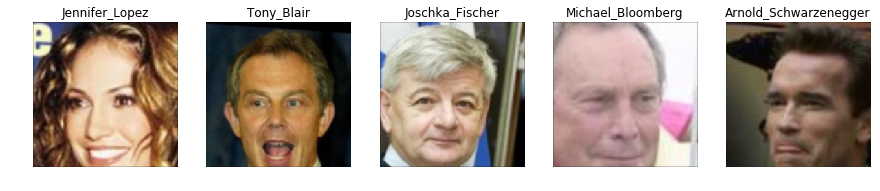

In [13]:
visualize(x_train, y_train, function = lambda x:preprocess_imgs(x)[0])

The neural network is already trained on the other face dataset. You should use this network as feature extractor to get descriptors of the faces. You can choose any hidden layer you need (or several layers) to extract features and any classification method.

In [14]:
import h5py
from keras.models import load_model
model = load_model('face_recognition_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168    
__________

Here is an example of using the network as feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3), so you can input several images simultaneously and get their face descriptors of shape (n_images, n_components).

In [15]:
def get_layer_output(images, layer = 'fc6'):
    assert len(images.shape)==4, 'Wrong input dimentionality!'
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    network_output = model.get_layer(layer).output
    feature_extraction_model = Model(model.input, network_output)
    
    output = feature_extraction_model.predict(images)
    return output

In [16]:
img = cv2.resize(x_train['0.jpg'], (224,224)).reshape(1,224,224,3)
out = get_layer_output(img)
print(out.shape)

(1, 4096)


### Training classifier (2 points)


You have to implement class $\tt{Classifier}$ with methods $\tt{fit}$, $\tt{classify}$\_$\tt{images}$ and $\tt{classify}$\_$\tt{videos}$ in the cell below. 
The method $\tt{Classifier.fit}$ gets two dictionaries as input: train images and labels, and trains the classifier to predict the person shown on the image.
$\tt{Classifier.classify}$\_$\tt{images}$ gets the dictionary of test images (with filenames as keys) as input and should return the dictionary of the predicted labels.
$\tt{Classifier.classify}$\_$\tt{videos}$ is similar to the previous one, but gets the dictionary of test videos (with video as keys) as input.

To classify video you can combine the predictions for its frames any way you want (averaging, voting, etc.).
If video classification takes too long you can use face detector not in all the frames but every few frames while preprocessing video frames. 
Besides, sometimes the face is hardly detected on the image and the frame in which the detector works wrong can add noise to the prediction. Hence, the result of the prediction without using such frames may be better.

In [17]:
from sklearn.neighbors import KNeighborsClassifier as kNN
from skimage.io import imread
import cv2
from os.path import join
from collections import Counter
import datetime
from skimage.transform import rotate
import random

class Classifier():
    def __init__(self, feature_extractor_fn):
        self.knn_model = kNN(n_neighbors = 3, weights='distance')
        self.feature_extractor_fn = feature_extractor_fn

    def fit(self, train_imgs, train_labels, aug_factor = 3):
        imgs = [train_imgs["%d.jpg" % i] for i in range(len(train_imgs))]
        
        for _ in range(aug_factor):
            for i in range(len(train_imgs)):
                aug_img = rotate(imgs[i], 2 * (random.random() - 0.5) * 15, resize = True)
                aug_img = (255 * aug_img).astype(np.uint8)
                
                imgs.append(aug_img)
        
        preprocessed_imgs = preprocess_imgs(imgs)
        print("training preprocessing done.  %s" % datetime.datetime.now())
        features = self.feature_extractor_fn(preprocessed_imgs)
        print('training features extracted  %s' % datetime.datetime.now())
        
        labels = [train_labels['%d.jpg' % i] for i in range(len(train_labels))]
        labels += labels * aug_factor
        
        self.knn_model.fit(features, labels)
        print('knn model trained  %s' % datetime.datetime.now())

    def classify_images(self, test_imgs):
        imgs = []
        keys = []
        
        for k, v in test_imgs.items():
            imgs.append(v)
            keys.append(k)
        
        preprocessed_imgs = preprocess_imgs(imgs)
        print('testing preprocessing done  %s' % datetime.datetime.now())
        
        features = self.feature_extractor_fn(preprocessed_imgs)
        print('test features extracted  %s' % datetime.datetime.now())
        
        pred_labels = self.knn_model.predict(features)
        print('test labels predicted  %s' % datetime.datetime.now())
        return {keys[i]: pred_labels[i] for i in range(len(test_imgs))}
       
        
    def classify_videos(self, test_video, num_frames = 5):
        imgs = []
        keys = []
        
        for k, v in test_video.items():
            keys += [k] * num_frames
            
            step = max(int(len(v) / num_frames), 1)
            for i in range(num_frames):
                imgs.append(v[i * step])
            
        preprocessed_imgs = preprocess_imgs(imgs)
        print('testing preprocessing done  %s' % datetime.datetime.now())
        features = self.feature_extractor_fn(preprocessed_imgs)
        print('test features extracted  %s' % datetime.datetime.now())
        
#         pred_probs = self.knn_model.predict_proba(features)
#         dists, _ = self.knn_model.kneighbors(features, n_neighbors=1, return_distance=True)
        
#         pred_labels_output = {}
#         for i in range(len(test_video)):
#             total_scores_map = {}
#             num_scores_map = {}
#             for j in range(num_frames):
#                 scores_row = pred_probs[i * num_frames + j]
                
#                 for k in range(scores_row.shape[0]):
#                     if scores_row[k] > 0:
#                         pred_class = self.knn_model.classes_[k]
#                         if pred_class not in total_scores_map:
#                             total_scores_map[pred_class] = 0
#                             num_scores_map[pred_class] = 0
#                         total_scores_map[pred_class] += scores_row[k] / dists[i * num_frames + j, 0]
#                         num_scores_map[pred_class] += 1
                        
#             best_class_name = ""
#             best_score = -float('inf')
#             for class_name in total_scores_map.keys():
#                 s = total_scores_map[class_name] / num_scores_map[class_name] 
#                 if s > best_score:
#                     best_score = s
#                     best_class_name = class_name
                    
#             pred_labels_output[keys[i * num_frames]] = best_class_name
#         print('test labels predicted  %s' % datetime.datetime.now())
            
#         return pred_labels_output
        
        pred_labels = self.knn_model.predict(features)
        
        pred_labels_output = {}
        for i in range(len(test_video)):
            label_counter = Counter(pred_labels[i * num_frames : (i + 1) * num_frames])
        
            pred_labels_output[keys[i * num_frames]] = label_counter.most_common(1)[0][0]
        print('test labels predicted  %s' % datetime.datetime.now())
        
        return pred_labels_output


Now we can build the classifier, fit it and use to predict the labels of testing images.

In [18]:
img_classifier = Classifier(get_layer_output)
img_classifier.fit(x_train, y_train)
y_out = img_classifier.classify_images(x_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


training preprocessing done.  2018-11-10 23:59:40.940866
training features extracted  2018-11-11 00:18:28.300143
knn model trained  2018-11-11 00:18:29.211495
testing preprocessing done  2018-11-11 00:18:56.364464
test features extracted  2018-11-11 00:24:30.807525
test labels predicted  2018-11-11 00:24:46.514338


### Image classification quality (2 points)

Let us check the accuracy of your classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.90, to obtain 2 points — at least 0.95.

In [19]:
def check_test(output, gt):
    correct = 0.
    total = len(gt)
    for k, v in gt.items():
        if output[k] == v:
            correct += 1
    accuracy = correct / total

    return 'Classification accuracy is %.4f' % accuracy

In [20]:
print(check_test(y_out, y_test))

Classification accuracy is 0.9641


### Video classification quality (2 points)

Let us check the quality of video classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.80, to obtain 2 points — at least 0.85.

In [21]:
video_classifier = Classifier(get_layer_output)
video_classifier.fit(video_train, train_labels)
y_video_out = video_classifier.classify_videos(video_test, num_frames=5)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


training preprocessing done.  2018-11-11 00:27:07.542973
training features extracted  2018-11-11 00:52:39.827362
knn model trained  2018-11-11 00:52:40.656346
testing preprocessing done  2018-11-11 00:52:58.155205
test features extracted  2018-11-11 00:57:10.563705
test labels predicted  2018-11-11 00:57:20.908186


In [22]:
print(check_test(y_video_out, test_labels))

Classification accuracy is 0.7286
